In [16]:
import geopandas as gpd
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RegularGridInterpolator
from scipy.io import savemat
import os
import matplotlib.colors as mcolors

# Functions


In [17]:
def xyz_geotiff(img):
    band = img.GetRasterBand(1)
    z = band.ReadAsArray().T
    width = img.RasterXSize
    height = img.RasterYSize
    gt = img.GetGeoTransform()
    minx = gt[0]
    miny = gt[3]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3] + width*gt[4] + height*gt[5]
    x = np.linspace(minx,maxx,width)
    y = np.linspace(miny,maxy,height)
    
    y = np.flip(y)
    z = np.flip(z,1)
    
    return x,y,z

# Reading data

In [18]:
# load the centerline
centerline = gpd.read_file('Data/picnic_centreline.shp').geometry.values[0]

# load bathy
localdir    = 'Data/2023_bed_merged_picnic_extent.tif'
x,y,z       = xyz_geotiff(gdal.Open(localdir, gdal.GA_ReadOnly))
z[z==-9999] = np.nan

# Analysis

In [26]:
# get x,y coords of centreline as array
clxlres, clylres = np.asarray(centerline.xy)

# remove bad point
spuriouspoint = np.argwhere((clxlres>319353.87)&(clxlres<319353.88))[0][0] # identification of point
clxlres = np.delete(clxlres,spuriouspoint)
clylres = np.delete(clylres,spuriouspoint) # removes problematic point from code

In [20]:
## Get distance along centreline
# Find euclidian distance along centreline
e_dis = np.cumsum((np.diff(clxlres)**2+np.diff(clylres)**2)**0.5)

# add 0 at start
cldislres = np.concatenate((np.asarray([0]),e_dis))


In [21]:
# ddh = difference distance high-resolution
ddh  = 1
# define maximum spanwise distance away from centerline 
# dh = distance high-resolution
dh   = 50

# make new grid
#spanwise
cl_span = np.arange(-dh,dh+ddh,ddh)
#streamwise
cldishres = np.arange(np.ceil(cldislres[0]),np.floor(cldislres[-1]),ddh)

In [22]:
# find the x y coordinates along the high-resolution centerline
# create interpolation functions for x and y seperately from the low-resolution data
idxl = interp1d(cldislres,clxlres,kind='cubic') # interpolation function of x coord vs centreline distance
idyl = interp1d(cldislres,clylres,kind='cubic') # interpolation function of y coord vs centreline distance

# do the interpolation, so now we have the x and y coordinates along centerline
clxhres = idxl(cldishres) # find x coord at each centreline distance 1m resolution
clyhres = idyl(cldishres) # find y coord at each centreline distance 1m resolution

# get the angle of the normal vector across the high-resolution centerline at each point
clah = np.arctan2(-np.gradient(clxhres),np.gradient(clyhres))

In [23]:
# now make the x y grid of the high-resolution data
# ogxh = old grid x high-resolution
# first dimension is spanwise, second is streamwise
# spanwise cl_span is the hypotenuse, x is the adjacent, y is the opposite, center point is [clxhres,clyhres]
ogxhres = cl_span[:,None]*np.cos(clah[None,:]) + clxhres[None,:] 
ogyhres = cl_span[:,None]*np.sin(clah[None,:]) + clyhres[None,:]

# ngxh = new grid x high-resolution
# spanwise is clnd, streamwise is cldh
ngxhres = cl_span[:,None]*np.ones(len(cldishres))
ngyhres = cldishres[None,:]*np.ones(len(cl_span))[:,None]

# now make the z values on the new high-resolution x y grid
# create the interpolation function for the original tif data
ixyz = RegularGridInterpolator((x,y),z,bounds_error=False)
# do the interpolation onto each point of [ogxh,ogyh]
# must reshape the data since this function works on a list of points, but we want a grid
gzh  = np.reshape(ixyz(np.array([ogxhres.flatten(),ogyhres.flatten()]).T),np.shape(ogxhres))


# Plots

In [24]:
#crop bathy so it doesnt load everything when plotting
section_start = 5100
section_length = 400
midway = int(section_length/2)
buff = 25

ogx_crop = ogxhres[:,section_start:section_start+section_length]
ogy_crop = ogyhres[:,section_start:section_start+section_length]
ngx_crop = ngxhres[:,section_start:section_start+section_length]
ngy_crop = ngyhres[:,section_start:section_start+section_length]

xmin = np.min(ogx_crop)-buff
xmax = np.max(ogx_crop)+buff
ymin = np.min(ogy_crop)-buff
ymax = np.max(ogy_crop)+buff

xt = x[(x>=xmin)&(x<=xmax)]
yt = y[(y>=ymin)&(y<=ymax)]
zt = z[(x>=xmin)&(x<=xmax)][:,(y>=ymin)&(y<=ymax)]


/var/folders/qp/730rtpld0y3cvn9lscp9l7mh0000gn/T/ipykernel_11890/3152736607.py:50: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(ogx_crop,ogy_crop,np.ones_like(ogx_crop),cmap=grey_cmap)
/var/folders/qp/730rtpld0y3cvn9lscp9l7mh0000gn/T/ipykernel_11890/3152736607.py:75: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb1 = fig.colorbar(pc1,cax=cbar1_ax, ticks=elevationticks)


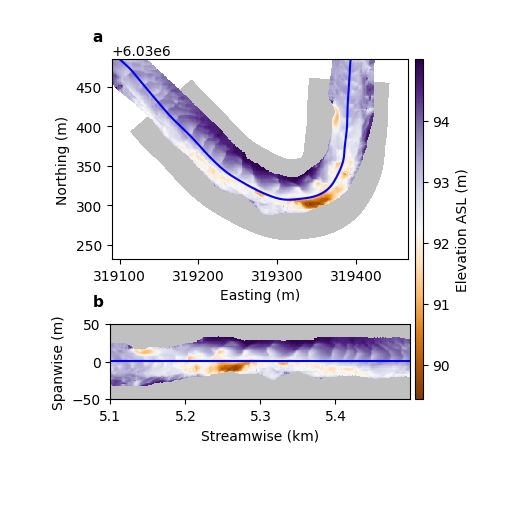

In [25]:
draft = False

# setting customise variables
hbuf = 0.13 #height buffer between different axis
cbbuf = 0.01 # buffer between colour bar and axis
cbw  = 0.015 #colour bar 
width = 0.6 #0.5
thinh  = 0.15 #0.13
wideh = 0.4 #0.34
labbuf  = 0.035 # panel label buffer

ax1l,ax1b,ax1w,ax1h = 0.2,0.5,width, wideh # left, bottom, width, height
ax2l,ax2b,ax2w,ax2h = ax1l,ax1b-thinh-hbuf,width, thinh
cb1l,cb1b,cb1w,cb1h = ax1l+ax1w+cbbuf,ax2b,cbw,thinh+wideh+hbuf 

# values for setting axis ticks 
m2km = lambda x, _: f'{x/1000:g}'
elevationticks = [90,91,92,93,94]

# setting centerline extent 
clmax = 13000 # max dis of centerline 
clmax_ID = cldislres<=clmax
extentbuf = 150

## plotting
plt.figure(figsize=(5,5))
fig = plt.gcf() 

# axis to show the boundary of figure
ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)

# making a,b figure labels
ax00.text(ax1l-labbuf,ax1b+ax1h+labbuf,'a',fontsize=11, weight='bold')
ax00.text(ax2l-labbuf,ax2b+ax2h+labbuf,'b',fontsize=11, weight='bold')

if draft: #if draft is true
    plt.xticks([]) #removes ticks
    plt.yticks([])
else:
    plt.axis('off') #turns outside axis off

# plot og section crop
ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
plt.axis('square')
cl_n = ax1.plot(clxhres,clyhres,color = 'b', label='High resolution centerline') # plot new centerline
color = 'silver'  
grey_cmap = mcolors.ListedColormap([color]) 
plt.pcolor(ogx_crop,ogy_crop,np.ones_like(ogx_crop),cmap=grey_cmap) 
pc1 = plt.pcolor(xt,yt,zt.T,cmap='PuOr') # plots bathy

ax1.set_ylim(ymin,ymax)
ax1.set_xlim(xmin,xmax)
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')
ax1.locator_params(axis='x', nbins=4) 

# plot new grid section crop
ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])
plt.axis('square')
plt.plot(ngyhres[51,:],ngxhres[51,:], color ='b') # plot new centerline
plt.pcolor(ngy_crop,ngx_crop,np.ones_like(ngx_crop),cmap=grey_cmap, rasterized=True)
pc2 = plt.pcolor(ngy_crop, ngx_crop,gzh[:,section_start:section_start+section_length],cmap='PuOr', rasterized=True) # interpolated bathy

ax2.xaxis.set_major_formatter(m2km)
ax2.set_ylim(-dh,dh)
ax2.set_xlim(np.min(ngy_crop),np.max(ngy_crop))
ax2.set_ylabel('Spanwise (m)') 
ax2.set_xlabel('Streamwise (km)')
ax2.locator_params(axis='x', nbins=6) 

# makes colour bar
cbar1_ax = fig.add_axes([cb1l,cb1b,cb1w,cb1h])
cb1 = fig.colorbar(pc1,cax=cbar1_ax, ticks=elevationticks) 
cbar1_ax.yaxis.set_label_position('right')
cbar1_ax.yaxis.set_ticks_position('right')
cb1.ax.set_ylabel('Elevation ASL (m)')
cb1.ax.set_yticklabels(elevationticks)

# saving figure
if draft==False:
    plt.savefig('curvi_method_example_smaller.png',dpi=300)